In [7]:
# -*- coding: utf-8 -*-
"""
Swin Transformer + Temporal Attention + Tabular Multimodal Energy Prediction
COMPLETE SPATIO-TEMPORAL ARCHITECTURE
"""

import os
import pandas as pd
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomRotation, RandomHorizontalFlip
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import cv2
import warnings
import matplotlib.pyplot as plt

try:
    import timm
    print("✅ timm library loaded successfully!")
except ImportError:
    print("❌ timm not found. Please install: pip install timm")
    raise

warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")
print(f"📦 timm version: {timm.__version__}")

✅ timm library loaded successfully!
✅ Libraries loaded successfully!
🔥 PyTorch version: 2.9.0+cu126
🎮 CUDA available: True
📦 timm version: 1.0.21


In [8]:
# ==================== TABULAR ENCODER ====================
class TabularEncoder(nn.Module):
    """
    Clean tabular encoder - NO DATA LEAKAGE
    Features (6 total):
    - log_population, log_area, log_density
    - month_sin, month_cos, year_normalized
    """
    def __init__(self, num_features=6, output_dim=512, dropout=0.3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = x.float()
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        return self.encoder(x)

print("✅ Tabular encoder ready - NO LEAKAGE!")

✅ Tabular encoder ready - NO LEAKAGE!


In [9]:
# ==================== FUSION LAYER ====================
class FusionLayer(nn.Module):
    """Simple concatenation + MLP fusion"""
    def __init__(self, vision_dim=512, tabular_dim=512, output_dim=512, dropout=0.3):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(vision_dim + tabular_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, vision_feat, tabular_feat):
        combined = torch.cat([vision_feat, tabular_feat], dim=-1)
        return self.fusion(combined)

print("✅ Fusion layer ready!")

✅ Fusion layer ready!


In [10]:
# ==================== SWIN TEMPORAL MODEL ====================
class SwinTemporalModel(nn.Module):
    """
    Swin + Temporal Attention + Tabular Multimodal Model
    Architecture:
    1. Swin Transformer (spatial, time-distributed) → 768-dim
    2. Vision Projection → 512-dim
    3. Temporal Attention (Transformer Encoder) → 512-dim contextualized
    4. Tabular Encoder (time-distributed) → 512-dim
    5. Fusion (concat + MLP) → 512-dim
    6. Prediction Head → 1
    """
    def __init__(self,
                 swin_variant='swin_tiny_patch4_window7_224',
                 num_tabular_features=6,
                 dropout=0.3,
                 seq_len=12,
                 pretrained=True):
        super().__init__()

        print(f"\n🔨 Building Swin Temporal Model...")
        print(f"   Vision: {swin_variant}")
        print(f"   Tabular features: {num_tabular_features}")
        print(f"   Sequence length: {seq_len}")
        print(f"   Pretrained: {pretrained}")

        # 1. Swin Transformer (Spatial Backbone - Shared across time)
        self.swin = timm.create_model(
            swin_variant,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            in_chans=1,
            img_size=64
        )

        swin_out_dim = self.swin.num_features
        print(f"   Swin output dim: {swin_out_dim}")

        # 2. Vision projection
        self.vision_proj = nn.Sequential(
            nn.Linear(swin_out_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 3. Temporal Attention Module (THE NEW MECHANISM)
        self.seq_len = seq_len
        # Learnable positional encoding for temporal dimension
        self.temporal_pos = nn.Parameter(torch.zeros(1, seq_len, 512))
        nn.init.trunc_normal_(self.temporal_pos, std=0.02)
        
        # Transformer encoder for temporal modeling
        enc_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=1024,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.temporal_encoder = nn.TransformerEncoder(enc_layer, num_layers=2)
        
        print(f"   🕐 Temporal Attention: 2-layer Transformer (8 heads)")

        # 4. Tabular encoder
        self.tabular_encoder = TabularEncoder(
            num_features=num_tabular_features,
            output_dim=512,
            dropout=dropout
        )

        # 5. Fusion layer
        self.fusion = FusionLayer(
            vision_dim=512,
            tabular_dim=512,
            output_dim=512,
            dropout=dropout
        )

        # 6. Prediction head
        self.head = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

        print(f"   ✅ Temporal model built!")

    def freeze_backbone(self):
        """Freeze ONLY Swin backbone"""
        for p in self.swin.parameters():
            p.requires_grad = False
        print("   🔒 Swin backbone frozen")

    def unfreeze_all(self):
        """Unfreeze everything"""
        for p in self.parameters():
            p.requires_grad = True
        print("   🔓 All parameters unfrozen")

    def forward(self, img, tabular):
        """
        Args:
            img: (B, 12, 1, 64, 64) - sequence of 12 monthly nightlight images
            tabular: (B, 12, 6) - sequence of 12 monthly features
        Returns:
            predictions: (B, 12, 1) - predictions for each month
        """
        b, t, c, h, w = img.shape
        
        # A. Spatial Extraction (Time-Distributed)
        # Flatten temporal dimension: (B, 12, 1, 64, 64) → (B*12, 1, 64, 64)
        x = img.view(b * t, c, h, w)
        
        # Extract spatial features using Swin
        vis = self.swin(x)  # (B*12, 768)
        vis = self.vision_proj(vis)  # (B*12, 512)
        
        # Reshape back to temporal: (B*12, 512) → (B, 12, 512)
        vis = vis.view(b, t, -1)
        
        # B. Temporal Attention
        # Add learnable positional encoding
        vis = vis + self.temporal_pos  # (B, 12, 512)
        
        # Apply temporal transformer to capture temporal dependencies
        vis = self.temporal_encoder(vis)  # (B, 12, 512) - contextualized
        
        # C. Tabular Encoding (Time-Distributed)
        # Flatten: (B, 12, 6) → (B*12, 6)
        tab = tabular.view(b * t, -1)
        tab = self.tabular_encoder(tab)  # (B*12, 512)
        # Reshape back: (B*12, 512) → (B, 12, 512)
        tab = tab.view(b, t, -1)
        
        # D. Fusion & Prediction
        # Fuse vision and tabular for each timestep
        fused = self.fusion(vis, tab)  # (B, 12, 512)
        
        # Predict for each timestep
        output = self.head(fused)  # (B, 12, 1)
        
        return output

print("\n✅ Swin Temporal Model assembled!")
print("\n📊 Architecture Summary:")
print("   1. Swin Transformer (pretrained, spatial) - ~28M params")
print("   2. Vision Projection - ~0.5M params")
print("   3. Temporal Attention (2-layer Transformer) - ~2M params")
print("   4. Tabular Encoder (6 features) - ~0.3M params")
print("   5. Fusion Layer - ~1M params")
print("   6. Prediction Head - ~0.5M params")
print("   ✨ TOTAL: ~32M parameters")



✅ Swin Temporal Model assembled!

📊 Architecture Summary:
   1. Swin Transformer (pretrained, spatial) - ~28M params
   2. Vision Projection - ~0.5M params
   3. Temporal Attention (2-layer Transformer) - ~2M params
   4. Tabular Encoder (6 features) - ~0.3M params
   5. Fusion Layer - ~1M params
   6. Prediction Head - ~0.5M params
   ✨ TOTAL: ~32M parameters


In [11]:
# ==================== TEMPORAL DATASET ====================
class TemporalMultimodalDataset(Dataset):
    """
    Dataset for temporal sequences
    Input shapes:
    - images: (Num_Sequences, 12, 1, 64, 64)
    - features: (Num_Sequences, 12, 6)
    - targets: (Num_Sequences, 12, 1)
    """
    def __init__(self, images, features, targets=None):
        self.images = torch.FloatTensor(images)
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets) if targets is not None else None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.targets is not None:
            return self.images[idx], self.features[idx], self.targets[idx]
        return self.images[idx], self.features[idx]

# ==================== DATA LOADING ====================
def load_temporal_multimodal_data(csv_path, image_dir):
    """
    Load temporal sequences (12 months) + clean tabular features
    CRITICAL: Groups by Country-Year, only keeps complete 12-month sequences
    """
    df = pd.read_csv(csv_path)
    df = df[(df['Energy Use per Capita (kWh)'] > 0) & 
            (df['Population'] > 0) & 
            (df['Area (Sq. Km)'] > 0)]

    df['date'] = pd.to_datetime(df['Date (month/year)'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df = df.sort_values(['Country', 'date']).reset_index(drop=True)

    for col in ['Population', 'Area (Sq. Km)']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Feature engineering (NO LEAKAGE)
    df['log_population'] = np.log1p(df['Population'].astype(float))
    df['log_area'] = np.log1p(df['Area (Sq. Km)'].astype(float))
    df['density'] = df['Population'].astype(float) / (df['Area (Sq. Km)'].astype(float) + 1)
    df['log_density'] = np.log1p(df['density'])
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(float) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(float) / 12)
    year_min = df['year'].min()
    year_max = df['year'].max()
    df['year_normalized'] = (df['year'].astype(float) - year_min) / (year_max - year_min + 1e-8)

    df = df.fillna(0)

    print(f"\n🔧 Clean Feature Engineering (NO LEAKAGE):")
    print(f"   ✅ 6 features created:")
    print(f"      - log_population, log_area, log_density")
    print(f"      - month_sin, month_cos, year_normalized")

    feature_cols = [
        'log_population', 'log_area', 'log_density',
        'month_sin', 'month_cos', 'year_normalized'
    ]

    grouped_images, grouped_features, grouped_targets, grouped_years = [], [], [], []
    
    print("\n🖼️ Loading temporal sequences (12 months)...")
    skipped_incomplete = 0
    skipped_missing = 0

    # Group by Country and Year
    for (country, year), group in df.groupby(['Country', 'year']):
        # STRICT REQUIREMENT: Only full years (12 months)
        if len(group) != 12:
            skipped_incomplete += 1
            continue
        
        # Ensure Jan->Dec order
        group = group.sort_values('month').reset_index(drop=True)
        
        # Extract images for this sequence
        seq_imgs = []
        valid_seq = True
        
        for _, row in group.iterrows():
            img_path = os.path.join(image_dir, row['Country'],
                                    f"{row['Country']}_{row['year']}_{row['month']:02d}.tif")
            
            if not os.path.exists(img_path):
                valid_seq = False
                skipped_missing += 1
                break
            
            try:
                with rasterio.open(img_path) as src:
                    image = src.read(1)
                    
                    if image is None or np.isnan(image).any() or np.isinf(image).any():
                        valid_seq = False
                        break
                    
                    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
                    seq_imgs.append(image)
            except Exception:
                valid_seq = False
                break
        
        if valid_seq and len(seq_imgs) == 12:
            # Stack 12 images -> (12, 64, 64)
            grouped_images.append(np.stack(seq_imgs))
            
            # Extract features and targets
            grouped_features.append(group[feature_cols].values)  # (12, 6)
            grouped_targets.append(group['Energy Use per Capita (kWh)'].values.reshape(-1, 1))  # (12, 1)
            grouped_years.append(year)

    print(f"\n📊 Temporal Data Loading Summary:")
    print(f"   ✅ Successfully loaded: {len(grouped_images)} complete sequences")
    print(f"   ⚠️  Skipped incomplete years: {skipped_incomplete}")
    print(f"   ⚠️  Skipped missing images: {skipped_missing}")
    print(f"   📅 Total months: {len(grouped_images) * 12}")

    if len(grouped_images) == 0:
        raise ValueError("No valid temporal sequences loaded!")

    # Normalize images globally
    all_pixels = np.concatenate([seq.flatten() for seq in grouped_images])
    global_min, global_max = np.percentile(all_pixels, 1), np.percentile(all_pixels, 99)

    print(f"\n🖼️ Image normalization:")
    print(f"   Min (1st percentile): {global_min:.2f}")
    print(f"   Max (99th percentile): {global_max:.2f}")

    images = []
    for seq in grouped_images:
        # Normalize each image in sequence
        norm_seq = []
        for img in seq:
            norm_img = np.clip((img - global_min) / (global_max - global_min + 1e-8), 0, 1)
            norm_img = np.nan_to_num(norm_img, nan=0.0, posinf=1.0, neginf=0.0)
            norm_seq.append(norm_img[np.newaxis, :, :])  # Add channel dim
        images.append(np.stack(norm_seq))  # (12, 1, 64, 64)

    # Final Stack -> (Total_Sequences, 12, 1, 64, 64)
    images = np.stack(images)
    features = np.stack(grouped_features)  # (Total_Sequences, 12, 6)
    targets = np.stack(grouped_targets)  # (Total_Sequences, 12, 1)
    years = np.array(grouped_years)

    print(f"\n📊 Final tensor shapes:")
    print(f"   Images: {images.shape}")
    print(f"   Features: {features.shape}")
    print(f"   Targets: {targets.shape}")

    # Log-transform targets
    print(f"\n📊 Target transformation:")
    print(f"   Original range: [{targets.min():.2f}, {targets.max():.2f}] kWh")
    targets_log = np.log1p(targets)
    print(f"   Log-transformed range: [{targets_log.min():.2f}, {targets_log.max():.2f}]")

    return images, features, targets_log, years

# ==================== EVALUATION ====================
def evaluate_temporal_model(model, loader, device, target_scaler):
    """Evaluation for temporal multimodal model"""
    model.eval()
    preds_scaled_log, targets_scaled_log = [], []

    with torch.no_grad():
        for batch in loader:
            imgs, feats, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            outputs = model(imgs, feats)  # (B, 12, 1)

            # Flatten temporal dimension for metrics
            preds_scaled_log.append(outputs.view(-1).cpu().numpy())
            targets_scaled_log.append(labels.view(-1).cpu().numpy())

    preds_scaled_log = np.concatenate(preds_scaled_log)
    targets_scaled_log = np.concatenate(targets_scaled_log)

    # Inverse transform
    preds_log = target_scaler.inverse_transform(preds_scaled_log.reshape(-1, 1)).ravel()
    targets_log = target_scaler.inverse_transform(targets_scaled_log.reshape(-1, 1)).ravel()

    # Convert back to original scale
    preds_orig = np.expm1(preds_log)
    targets_orig = np.expm1(targets_log)
    preds_orig = np.maximum(preds_orig, 0.0)

    # Calculate metrics
    mae_orig = mean_absolute_error(targets_orig, preds_orig)
    rmse_orig = np.sqrt(mean_squared_error(targets_orig, preds_orig))
    r2_orig = r2_score(targets_orig, preds_orig)
    pearson_r, _ = pearsonr(targets_orig, preds_orig)

    epsilon = 1e-8
    errors = np.abs((targets_orig - preds_orig) / (targets_orig + epsilon)) * 100
    mape = np.mean(np.clip(errors, 0, 300))
    wape = (np.sum(np.abs(targets_orig - preds_orig)) / (np.sum(np.abs(targets_orig)) + epsilon)) * 100
    smape = np.mean(200 * np.abs(targets_orig - preds_orig) / (np.abs(targets_orig) + np.abs(preds_orig) + epsilon))
    within_5 = np.mean(errors <= 5) * 100
    within_10 = np.mean(errors <= 10) * 100

    mae_scaled_log = mean_absolute_error(targets_scaled_log, preds_scaled_log)

    return {
        'loss_scaled_log': mae_scaled_log,
        'mae': mae_orig,
        'rmse': rmse_orig,
        'mape': mape,
        'wape': wape,
        'smape': smape,
        'r2': r2_orig,
        'pearson_r': pearson_r,
        'within_5': within_5,
        'within_10': within_10
    }

# ==================== TRAINING ====================
def train_temporal_multimodal_model(images, features, targets, years, device,
                                   swin_variant='swin_tiny_patch4_window7_224',
                                   pretrained=True):
    """
    FIXED 2-phase strategy for TEMPORAL model:
    Phase 1: Freeze Swin backbone ONLY, train rest (including temporal encoder)
    Phase 2: Unfreeze all with 5-group optimizer (temporal gets high LR)
    """

    # Time series split
    train_mask = years <= 2020
    val_mask = (years > 2020) & (years <= 2022)
    test_mask = years > 2022

    print(f"\n📊 Time Series Split:")
    print(f"   Train (≤2020): {train_mask.sum()} sequences ({train_mask.sum()*12} months)")
    print(f"   Val (2021-2022): {val_mask.sum()} sequences ({val_mask.sum()*12} months)")
    print(f"   Test (>2022): {test_mask.sum()} sequences ({test_mask.sum()*12} months)")

    # Scaling - need to flatten temporal dimension for fitting
    feat_scaler = RobustScaler()
    targ_scaler = RobustScaler()

    # Flatten: (N, 12, 6) -> (N*12, 6)
    train_feat_flat = features[train_mask].reshape(-1, features.shape[-1])
    train_targ_flat = targets[train_mask].reshape(-1, 1)
    
    feat_scaler.fit(train_feat_flat)
    targ_scaler.fit(train_targ_flat)

    # Scale and reshape back
    def scale_temporal_data(data, scaler):
        shape = data.shape
        flat = data.reshape(-1, shape[-1])
        scaled = scaler.transform(flat)
        return scaled.reshape(shape)

    train_feat = scale_temporal_data(features[train_mask], feat_scaler)
    train_targ = scale_temporal_data(targets[train_mask], targ_scaler)
    val_feat = scale_temporal_data(features[val_mask], feat_scaler)
    val_targ = scale_temporal_data(targets[val_mask], targ_scaler)
    test_feat = scale_temporal_data(features[test_mask], feat_scaler)
    test_targ = scale_temporal_data(targets[test_mask], targ_scaler)

    # Datasets - CRITICAL: Batch size reduced to 4
    train_ds = TemporalMultimodalDataset(images[train_mask], train_feat, train_targ)
    val_ds = TemporalMultimodalDataset(images[val_mask], val_feat, val_targ)
    test_ds = TemporalMultimodalDataset(images[test_mask], test_feat, test_targ)

    # CRITICAL: Batch size = 4 (means 48 images per batch: 4 sequences × 12 months)
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, pin_memory=True)

    print(f"\n⚠️  CRITICAL: Batch size = 4 (4 sequences × 12 months = 48 images)")

    # Model
    print("\n🔨 Building temporal multimodal model...")
    model = SwinTemporalModel(
        swin_variant=swin_variant,
        num_tabular_features=6,
        dropout=0.3,
        seq_len=12,
        pretrained=pretrained
    )

    model = model.to(device)
    print(f"   Total Params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

    criterion = nn.L1Loss()

    # ===================== PHASE 1: FREEZE BACKBONE ONLY =====================
    warmup_epochs = 15
    print(f"\n{'='*80}")
    print(f"🔒 PHASE 1: FREEZE SWIN BACKBONE ONLY")
    print(f"{'='*80}")
    print(f"Duration: {warmup_epochs} epochs")
    print(f"Frozen: Swin backbone ONLY")
    print(f"Training: Vision Projection + Temporal Encoder + Tabular + Fusion + Head")
    print(f"⚠️  CRITICAL: Temporal encoder MUST be trained here (randomly initialized)")

    model.freeze_backbone()

    # Ensure vision_proj and temporal_encoder are trainable
    for p in model.vision_proj.parameters():
        p.requires_grad = True
    for p in model.temporal_encoder.parameters():
        p.requires_grad = True

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    trainable_count = sum(p.numel() for p in trainable_params)
    print(f"\n📊 Phase 1 Trainable Parameters: {trainable_count/1e6:.2f}M")

    optimizer_phase1 = optim.AdamW(trainable_params, lr=5e-4, weight_decay=1e-4)
    scheduler_phase1 = CosineAnnealingLR(optimizer_phase1, T_max=warmup_epochs, eta_min=1e-6)

    best_wape_phase1 = float('inf')

    for epoch in range(warmup_epochs):
        model.train()
        total_loss = 0

        for imgs, feats, labels in train_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)

            optimizer_phase1.zero_grad()
            outputs = model(imgs, feats)  # (B, 12, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
            optimizer_phase1.step()

            total_loss += loss.item()

        train_loss_avg = total_loss / len(train_loader)
        val_metrics = evaluate_temporal_model(model, val_loader, device, targ_scaler)
        scheduler_phase1.step()

        print(f"[P1] Epoch {epoch+1:2d}/{warmup_epochs}: "
              f"TrLoss={train_loss_avg:.4f} | "
              f"ValLoss={val_metrics['loss_scaled_log']:.4f} | "
              f"WAPE={val_metrics['wape']:5.2f}% | "
              f"R²={val_metrics['r2']:.4f}")

        if val_metrics['wape'] < best_wape_phase1:
            best_wape_phase1 = val_metrics['wape']

    print(f"\n✅ Phase 1 Complete! Best WAPE: {best_wape_phase1:.2f}%")

    # ===================== PHASE 2: UNFREEZE ALL =====================
    print(f"\n{'='*80}")
    print(f"🔓 PHASE 2: UNFREEZE ALL - 5-GROUP OPTIMIZER")
    print(f"{'='*80}")

    model.unfreeze_all()

    # Organize parameters into groups
    swin_params = []
    vision_proj_params = []
    temporal_params = []
    tabular_params = []
    fusion_head_params = []
    no_decay_params = []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        if any(k in name.lower() for k in ('bias', 'ln', 'layernorm', 'norm')):
            no_decay_params.append(param)
        elif name.startswith('swin'):
            swin_params.append(param)
        elif name.startswith('vision_proj'):
            vision_proj_params.append(param)
        elif 'temporal' in name:  # CRITICAL: Temporal gets high LR
            temporal_params.append(param)
        elif name.startswith('tabular'):
            tabular_params.append(param)
        else:
            fusion_head_params.append(param)

    print(f"\n📊 Parameter Groups:")
    print(f"   Group 1 (Swin): {len(swin_params)} params, LR=1e-5")
    print(f"   Group 2 (Vision Proj): {len(vision_proj_params)} params, LR=5e-5")
    print(f"   Group 3 (Temporal): {len(temporal_params)} params, LR=5e-4 ⭐")
    print(f"   Group 4 (Tabular): {len(tabular_params)} params, LR=5e-4")
    print(f"   Group 5 (Fusion+Head): {len(fusion_head_params)} params, LR=5e-4")
    print(f"   Group 6 (No Decay): {len(no_decay_params)} params, LR=5e-4, WD=0")

    optimizer_phase2 = optim.AdamW([
        {'params': swin_params, 'lr': 1e-5, 'weight_decay': 0.05},
        {'params': vision_proj_params, 'lr': 5e-5, 'weight_decay': 0.05},
        {'params': temporal_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': tabular_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': fusion_head_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': no_decay_params, 'lr': 5e-4, 'weight_decay': 0.0}
    ])

    warmup_phase2_epochs = 5

    def lr_lambda(epoch):
        if epoch < warmup_phase2_epochs:
            return (epoch + 1) / warmup_phase2_epochs
        return 1.0

    warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer_phase2, lr_lambda)

    plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_phase2,
        mode='min',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        threshold=0.01,
        threshold_mode='rel'
    )

    print(f"\n🚀 Training Strategy (ADAPTIVE):")
    print(f"   - Warmup: {warmup_phase2_epochs} epochs")
    print(f"   - Main: ReduceLROnPlateau (adaptive to validation WAPE)")

    best_wape = float('inf')
    patience = 50
    epochs_no_improve = 0

    history = {
        'train_loss': [], 'val_loss': [], 'val_mape': [],
        'val_wape': [], 'val_r2': [], 'learning_rate': []
    }

    for epoch in range(200):
        model.train()
        total_loss = 0

        for imgs, feats, labels in train_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)

            optimizer_phase2.zero_grad()
            outputs = model(imgs, feats)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer_phase2.step()

            total_loss += loss.item()

        train_loss_avg = total_loss / len(train_loader)
        val_metrics = evaluate_temporal_model(model, val_loader, device, targ_scaler)

        if epoch < warmup_phase2_epochs:
            warmup_scheduler.step()
            current_lr = optimizer_phase2.param_groups[0]['lr']
        else:
            old_lr = optimizer_phase2.param_groups[0]['lr']
            plateau_scheduler.step(val_metrics['wape'])
            current_lr = optimizer_phase2.param_groups[0]['lr']

            if current_lr != old_lr:
                print(f"\n    📉 LR Reduced: {old_lr:.2e} → {current_lr:.2e}\n")

        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_metrics['loss_scaled_log'])
        history['val_mape'].append(val_metrics['mape'])
        history['val_wape'].append(val_metrics['wape'])
        history['val_r2'].append(val_metrics['r2'])
        history['learning_rate'].append(current_lr)

        warmup_tag = "[WARMUP]" if epoch < warmup_phase2_epochs else "[ADAPTIVE]"

        print(f"[P2] Epoch {epoch+1:3d} {warmup_tag}: "
              f"TrLoss={train_loss_avg:.4f} | "
              f"ValLoss={val_metrics['loss_scaled_log']:.4f} | "
              f"MAPE={val_metrics['mape']:5.2f}% | "
              f"WAPE={val_metrics['wape']:5.2f}% ⭐ | "
              f"R²={val_metrics['r2']:.4f} | "
              f"LR={current_lr:.2e}")

        if val_metrics['wape'] < best_wape:
            best_wape = val_metrics['wape']
            epochs_no_improve = 0

            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'wape': val_metrics['wape'],
                'mape': val_metrics['mape'],
                'r2': val_metrics['r2'],
                'feat_scaler': feat_scaler,
                'targ_scaler': targ_scaler
            }, 'best_temporal_model.pt')

            print(f"    💾 Best model saved: WAPE={val_metrics['wape']:.2f}%")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\n⏹ Early stopping at epoch {epoch+1}")
            print(f"   Best WAPE: {best_wape:.2f}%")
            break

    # ===================== TEST EVALUATION =====================
    print("\n" + "="*80)
    print("🎯 TEST SET EVALUATION")
    print("="*80)

    checkpoint = torch.load('best_temporal_model.pt', weights_only=False)
    model.load_state_dict(checkpoint['model'])

    test_metrics = evaluate_temporal_model(model, test_loader, device, targ_scaler)

    print(f"\n📊 TEST RESULTS:")
    print(f"   WAPE: {test_metrics['wape']:.2f}% ⭐")
    print(f"   MAPE: {test_metrics['mape']:.2f}%")
    print(f"   sMAPE: {test_metrics['smape']:.2f}%")
    print(f"   MAE: {test_metrics['mae']:.2f} kWh")
    print(f"   RMSE: {test_metrics['rmse']:.2f} kWh")
    print(f"   R²: {test_metrics['r2']:.4f}")
    print(f"   Pearson: {test_metrics['pearson_r']:.4f}")
    print(f"   Within ±5%: {test_metrics['within_5']:.1f}%")
    print(f"   Within ±10%: {test_metrics['within_10']:.1f}%")

    plot_temporal_training_history(history, test_metrics)

    return model, feat_scaler, targ_scaler, test_metrics, test_loader


def plot_temporal_training_history(history, test_metrics):
    """Plot comprehensive training history for temporal model"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('🚀 Swin Temporal Multimodal Training', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MAE Loss (log)')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(epochs, history['val_mape'], 'g-', label='MAPE', linewidth=2)
    axes[0, 1].plot(epochs, history['val_wape'], 'b-', label='WAPE ⭐', linewidth=2)
    axes[0, 1].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='Target 5%')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Error (%)')
    axes[0, 1].set_title('Validation Errors')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(epochs, history['val_r2'], 'm-', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('R² Score')
    axes[0, 2].set_title('Validation R²')
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 0].plot(epochs, history['learning_rate'], 'orange', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate (Adaptive)')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(epochs, history['val_wape'], 'b-', linewidth=2)
    axes[1, 1].axhline(y=test_metrics['wape'], color='r', linestyle='--', 
                       linewidth=2, label=f"Test: {test_metrics['wape']:.2f}%")
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('WAPE (%)')
    axes[1, 1].set_title('WAPE Progression')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].axis('off')
    summary = f"""
TEST RESULTS (TEMPORAL)

WAPE: {test_metrics['wape']:.2f}%
MAPE: {test_metrics['mape']:.2f}%
R²: {test_metrics['r2']:.4f}
Within ±5%: {test_metrics['within_5']:.1f}%
Within ±10%: {test_metrics['within_10']:.1f}%

Architecture:
- Swin Transformer (spatial)
- Temporal Attention (8-head, 2-layer)
- Tabular Encoder (6 features)
- Fusion Layer
- ~32M parameters

Training:
✅ Sequences: 12 months
✅ Batch size: 4 (48 images)
✅ Phase 1: Freeze backbone
   (temporal encoder trained)
✅ Phase 2: 5-group optimizer
   · Temporal: LR=5e-4 (high)
   · Adaptive LR scheduler
    """
    axes[1, 2].text(0.05, 0.5, summary, fontsize=9, verticalalignment='center',
                    fontfamily='monospace', 
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

    plt.tight_layout()
    plt.savefig('temporal_training_history.png', dpi=300, bbox_inches='tight')
    print("\n✅ Training plot saved as 'temporal_training_history.png'")
    plt.show()

🚀 SWIN TEMPORAL MULTIMODAL MODEL - SPATIO-TEMPORAL ARCHITECTURE
Architecture: Swin + Temporal Attention + Tabular
Sequences: 12-month temporal sequences
Features: Population, Area, Density, Seasonality, Time

⚠️  CRITICAL CHANGES:
   1. Sequences: 12 months per sample (Jan-Dec)
   2. Temporal Attention: 2-layer Transformer
   3. Batch size: 4 (48 images total)
   4. Temporal encoder: High LR in Phase 2

✅ CUDA Device: NVIDIA GeForce RTX 4070 Ti SUPER


🔧 Clean Feature Engineering (NO LEAKAGE):
   ✅ 6 features created:
      - log_population, log_area, log_density
      - month_sin, month_cos, year_normalized

🖼️ Loading temporal sequences (12 months)...

📊 Temporal Data Loading Summary:
   ✅ Successfully loaded: 750 complete sequences
   ⚠️  Skipped incomplete years: 93
   ⚠️  Skipped missing images: 76
   📅 Total months: 9000

🖼️ Image normalization:
   Min (1st percentile): 0.00
   Max (99th percentile): 16.64

📊 Final tensor shapes:
   Images: (750, 12, 1, 64, 64)
   Features: (750,

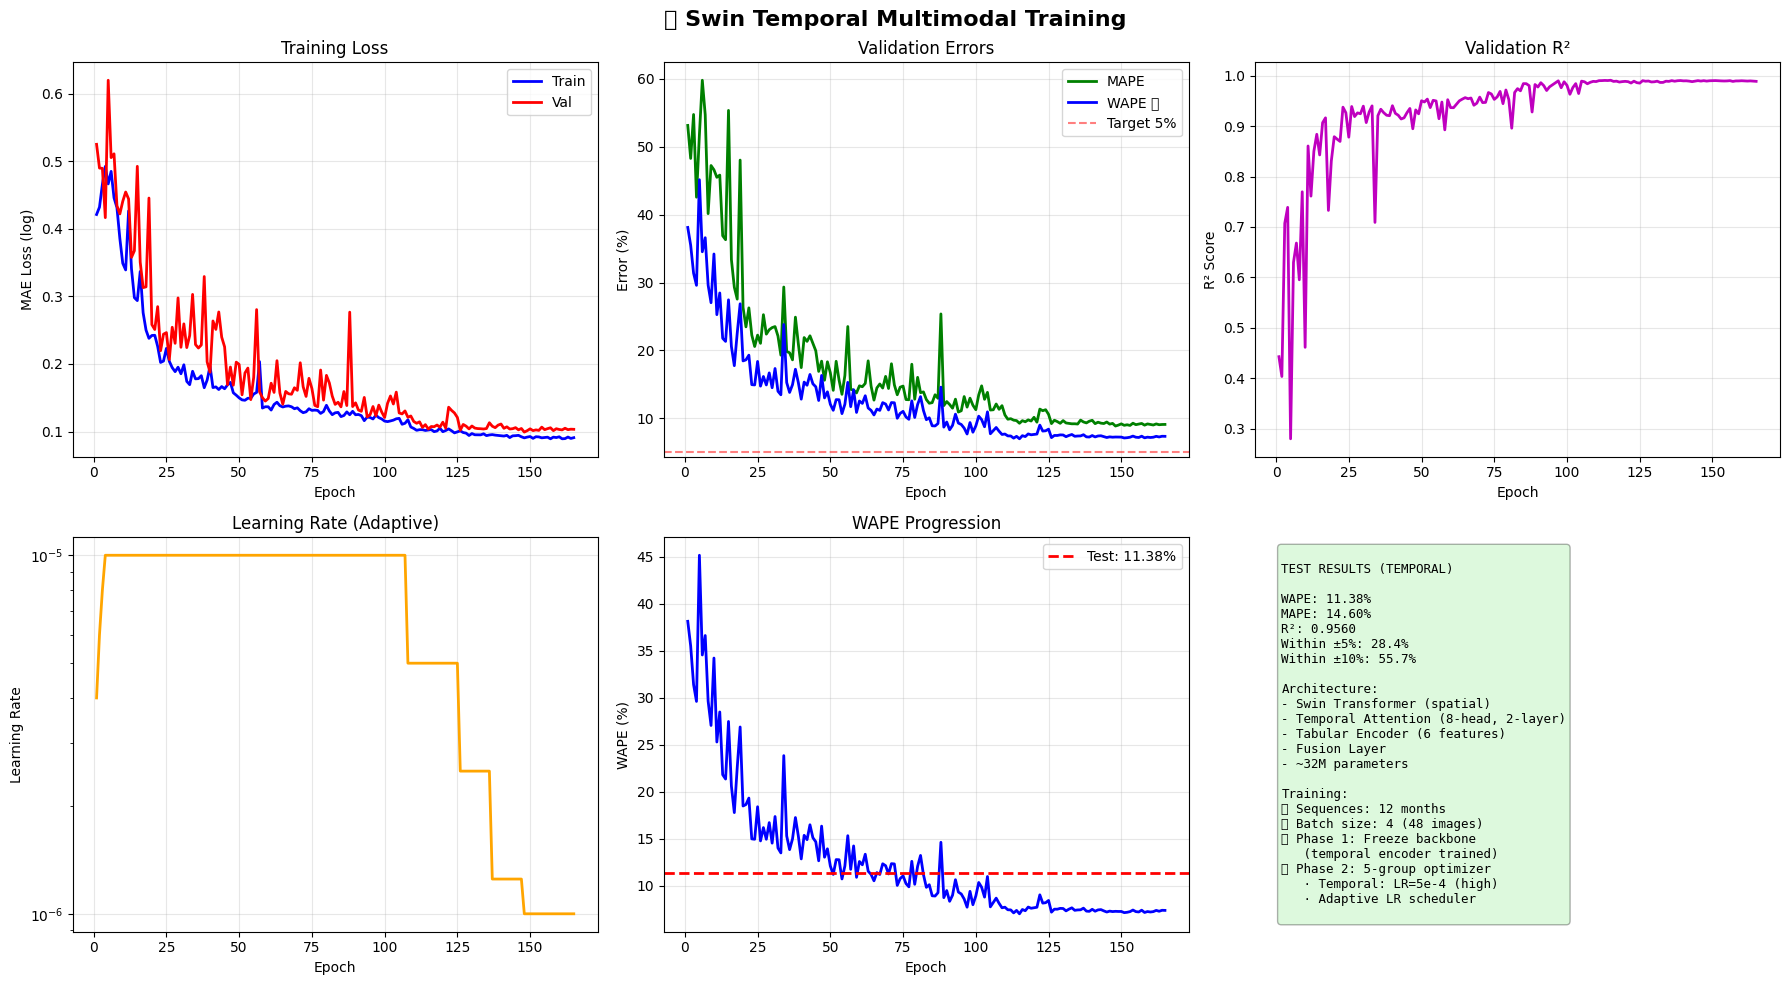


✅ TEMPORAL TRAINING COMPLETE!
🎯 Final Test WAPE: 11.38%
📊 Final Test MAPE: 14.60%
🏆 Model saved as: best_temporal_model.pt

⚠️  Key Features:
   1. Temporal sequences (12 months)
   2. Spatio-temporal architecture
   3. Batch size 4 (memory optimized)
   4. Temporal encoder trained properly


In [12]:
if __name__ == "__main__":
    print("="*80)
    print("🚀 SWIN TEMPORAL MULTIMODAL MODEL - SPATIO-TEMPORAL ARCHITECTURE")
    print("="*80)
    print("Architecture: Swin + Temporal Attention + Tabular")
    print("Sequences: 12-month temporal sequences")
    print("Features: Population, Area, Density, Seasonality, Time")
    print("\n⚠️  CRITICAL CHANGES:")
    print("   1. Sequences: 12 months per sample (Jan-Dec)")
    print("   2. Temporal Attention: 2-layer Transformer")
    print("   3. Batch size: 4 (48 images total)")
    print("   4. Temporal encoder: High LR in Phase 2")
    print("="*80 + "\n")

    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"✅ CUDA Device: {torch.cuda.get_device_name(0)}\n")

    csv_path = 'C:\\Users\\FA004\\Desktop\\satimg2\\data.csv'
    image_dir = 'C:\\Users\\FA004\\Desktop\\satimg2\\images'

    # Load temporal sequences
    images, features, targets, years = load_temporal_multimodal_data(csv_path, image_dir)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🎮 Device: {device}\n")

    # Train temporal model
    model, feat_scaler, targ_scaler, test_metrics, test_loader = train_temporal_multimodal_model(
        images, features, targets, years, device,
        swin_variant='swin_tiny_patch4_window7_224',
        pretrained=True
    )

    print("\n" + "="*80)
    print("✅ TEMPORAL TRAINING COMPLETE!")
    print("="*80)
    print(f"🎯 Final Test WAPE: {test_metrics['wape']:.2f}%")
    print(f"📊 Final Test MAPE: {test_metrics['mape']:.2f}%")
    print(f"🏆 Model saved as: best_temporal_model.pt")
    print("\n⚠️  Key Features:")
    print("   1. Temporal sequences (12 months)")
    print("   2. Spatio-temporal architecture")
    print("   3. Batch size 4 (memory optimized)")
    print("   4. Temporal encoder trained properly")
    print("="*80)